#Transfer Learning

In [2]:
%matplotlib inline

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [52]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

In [53]:
import numpy as np
import random
random_seed = 1109

torch.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

np.random.seed(random_seed)
random.seed(random_seed)

torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed)
os.environ['PYTHONHASHSEED'] = str(random_seed)

def _init_fn(worker_id):
    np.random.seed(int(random_seed))

#With Data Transform

##With LR 0.001

###Load Data

In [54]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/gdrive/MyDrive/Colab Notebooks/2021W_Postech_Study/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=2, worker_init_fn=_init_fn)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

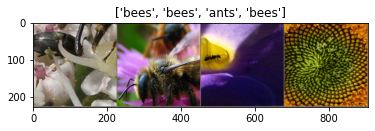

In [55]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

###Training the model

Training Func & Visualizing Func



In [56]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [57]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

###Train All layers

In [58]:
model_ft = models.googlenet(pretrained=True)        #googlenet
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth


  0%|          | 0.00/49.7M [00:00<?, ?B/s]

In [59]:
#Freeze 된 layer 갯수 확인
Not_learnable = 0
for layer in model_ft.parameters():
    if not layer.requires_grad:
        Not_learnable += 1
print(Not_learnable)

0


Train and evaluate
^^^^^^^^^^^^^^^^^^

It should take around 15-25 min on CPU. On GPU though, it takes less than a
minute.




In [60]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.7568 Acc: 0.6189
val Loss: 0.5836 Acc: 0.7320

Epoch 1/24
----------
train Loss: 0.6385 Acc: 0.6639
val Loss: 0.7000 Acc: 0.5359

Epoch 2/24
----------
train Loss: 0.6296 Acc: 0.6557
val Loss: 0.7907 Acc: 0.5294

Epoch 3/24
----------
train Loss: 0.6696 Acc: 0.6230
val Loss: 0.4547 Acc: 0.8170

Epoch 4/24
----------
train Loss: 0.5800 Acc: 0.7295
val Loss: 1.2290 Acc: 0.5621

Epoch 5/24
----------
train Loss: 0.6658 Acc: 0.6270
val Loss: 0.5805 Acc: 0.7255

Epoch 6/24
----------
train Loss: 0.6487 Acc: 0.6721
val Loss: 0.6100 Acc: 0.7190

Epoch 7/24
----------
train Loss: 0.5716 Acc: 0.6926
val Loss: 0.4941 Acc: 0.7647

Epoch 8/24
----------
train Loss: 0.5258 Acc: 0.7828
val Loss: 0.4799 Acc: 0.7908

Epoch 9/24
----------
train Loss: 0.5016 Acc: 0.7705
val Loss: 0.4559 Acc: 0.8105

Epoch 10/24
----------
train Loss: 0.4634 Acc: 0.7992
val Loss: 0.4152 Acc: 0.8039

Epoch 11/24
----------
train Loss: 0.4669 Acc: 0.7746
val Loss: 0.3803 Acc: 0.8301

Ep

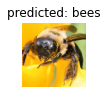

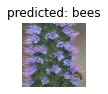

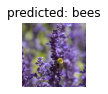

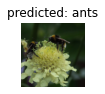

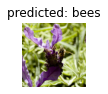

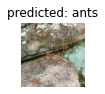

In [61]:
visualize_model(model_ft)

###Train Only FC layers

as feature extractor

In [62]:
model_conv = torchvision.models.googlenet(pretrained=True)
# Freeze all params
for param in model_conv.parameters():
    param.requires_grad = False

# 새로 fc layer를 만들면서 requires_grad=True로 지정
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.Adam(model_conv.fc.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [63]:
# Learnable Layer 갯수 확인
learnable = 0
for layer in model_conv.parameters():
    if layer.requires_grad:
        learnable += 1
print(learnable)        # weight and bias

2


Train and evaluate




In [64]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5851 Acc: 0.7213
val Loss: 0.3790 Acc: 0.9085

Epoch 1/24
----------
train Loss: 0.4871 Acc: 0.7828
val Loss: 0.2888 Acc: 0.9150

Epoch 2/24
----------
train Loss: 0.4424 Acc: 0.7951
val Loss: 0.2659 Acc: 0.9216

Epoch 3/24
----------
train Loss: 0.4202 Acc: 0.8074
val Loss: 0.2291 Acc: 0.9346

Epoch 4/24
----------
train Loss: 0.4600 Acc: 0.7787
val Loss: 0.2780 Acc: 0.9085

Epoch 5/24
----------
train Loss: 0.3939 Acc: 0.8361
val Loss: 0.2264 Acc: 0.9216

Epoch 6/24
----------
train Loss: 0.4304 Acc: 0.8074
val Loss: 0.2122 Acc: 0.9346

Epoch 7/24
----------
train Loss: 0.3619 Acc: 0.8279
val Loss: 0.2238 Acc: 0.9281

Epoch 8/24
----------
train Loss: 0.3504 Acc: 0.8566
val Loss: 0.2169 Acc: 0.9216

Epoch 9/24
----------
train Loss: 0.3679 Acc: 0.8443
val Loss: 0.2160 Acc: 0.9346

Epoch 10/24
----------
train Loss: 0.4514 Acc: 0.7951
val Loss: 0.2129 Acc: 0.9346

Epoch 11/24
----------
train Loss: 0.3665 Acc: 0.8525
val Loss: 0.2246 Acc: 0.9281

Ep

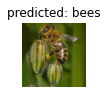

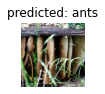

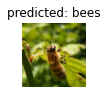

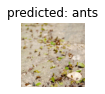

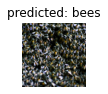

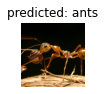

In [65]:
visualize_model(model_conv)

plt.ioff()
plt.show()

##With Lr 0.0001

###Train All layers

In [66]:
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.0001)

In [67]:
#Freeze 된 layer 갯수 확인
Not_learnable = 0
for layer in model_ft.parameters():
    if not layer.requires_grad:
        Not_learnable += 1
print(Not_learnable)

0


In [68]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.4709 Acc: 0.7787
val Loss: 0.4617 Acc: 0.8039

Epoch 1/24
----------
train Loss: 0.4355 Acc: 0.8197
val Loss: 0.3447 Acc: 0.8627

Epoch 2/24
----------
train Loss: 0.4198 Acc: 0.7951
val Loss: 0.3762 Acc: 0.8301

Epoch 3/24
----------
train Loss: 0.4196 Acc: 0.8115
val Loss: 0.3987 Acc: 0.8366

Epoch 4/24
----------
train Loss: 0.4922 Acc: 0.7623
val Loss: 0.4585 Acc: 0.7908

Epoch 5/24
----------
train Loss: 0.3953 Acc: 0.8402
val Loss: 0.3864 Acc: 0.8431

Epoch 6/24
----------
train Loss: 0.4181 Acc: 0.8033
val Loss: 0.4086 Acc: 0.8301

Epoch 7/24
----------
train Loss: 0.4483 Acc: 0.8033
val Loss: 0.3481 Acc: 0.8562

Epoch 8/24
----------
train Loss: 0.4528 Acc: 0.8115
val Loss: 0.4307 Acc: 0.8039

Epoch 9/24
----------
train Loss: 0.4086 Acc: 0.8115
val Loss: 0.4627 Acc: 0.8235

Epoch 10/24
----------
train Loss: 0.3421 Acc: 0.8566
val Loss: 0.3969 Acc: 0.8497

Epoch 11/24
----------
train Loss: 0.4075 Acc: 0.8238
val Loss: 0.4175 Acc: 0.8431

Ep

###Train Only FC layer

In [69]:
optimizer_conv = optim.Adam(model_conv.fc.parameters(), lr=0.0001)

In [70]:
# Learnable Layer 갯수 확인
learnable = 0
for layer in model_conv.parameters():
    if layer.requires_grad:
        learnable += 1
print(learnable)        # weight and bias

2


In [71]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.4179 Acc: 0.7910
val Loss: 0.2447 Acc: 0.9346

Epoch 1/24
----------
train Loss: 0.3537 Acc: 0.8811
val Loss: 0.2457 Acc: 0.9346

Epoch 2/24
----------
train Loss: 0.3784 Acc: 0.8361
val Loss: 0.2325 Acc: 0.9412

Epoch 3/24
----------
train Loss: 0.4368 Acc: 0.7705
val Loss: 0.2350 Acc: 0.9346

Epoch 4/24
----------
train Loss: 0.3802 Acc: 0.8402
val Loss: 0.2385 Acc: 0.9281

Epoch 5/24
----------
train Loss: 0.3830 Acc: 0.8279
val Loss: 0.2388 Acc: 0.9281

Epoch 6/24
----------
train Loss: 0.4014 Acc: 0.8115
val Loss: 0.2298 Acc: 0.9346

Epoch 7/24
----------
train Loss: 0.3693 Acc: 0.8361
val Loss: 0.2432 Acc: 0.9346

Epoch 8/24
----------
train Loss: 0.4228 Acc: 0.7951
val Loss: 0.2400 Acc: 0.9216

Epoch 9/24
----------
train Loss: 0.4646 Acc: 0.7705
val Loss: 0.2275 Acc: 0.9412

Epoch 10/24
----------
train Loss: 0.3887 Acc: 0.8443
val Loss: 0.2362 Acc: 0.9346

Epoch 11/24
----------
train Loss: 0.3745 Acc: 0.8320
val Loss: 0.2239 Acc: 0.9346

Ep

#With Only 224 Resize

other conditions are same as first case

##With LR 0.001

###Load Data

In [72]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
#        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
#        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
#        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/gdrive/MyDrive/Colab Notebooks/2021W_Postech_Study/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=2)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

###Train All layers

In [73]:
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001)

In [74]:
#Freeze 된 layer 갯수 확인
Not_learnable = 0
for layer in model_ft.parameters():
    if not layer.requires_grad:
        Not_learnable += 1
print(Not_learnable)

0


In [75]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6994 Acc: 0.6066
val Loss: 0.6217 Acc: 0.7451

Epoch 1/24
----------
train Loss: 0.6836 Acc: 0.5984
val Loss: 1.0682 Acc: 0.6601

Epoch 2/24
----------
train Loss: 0.6652 Acc: 0.6189
val Loss: 1.0797 Acc: 0.6536

Epoch 3/24
----------
train Loss: 0.5762 Acc: 0.6844
val Loss: 0.8266 Acc: 0.7190

Epoch 4/24
----------
train Loss: 0.6218 Acc: 0.6680
val Loss: 0.6390 Acc: 0.6536

Epoch 5/24
----------
train Loss: 0.5959 Acc: 0.7090
val Loss: 1.0697 Acc: 0.6536

Epoch 6/24
----------
train Loss: 0.6369 Acc: 0.6393
val Loss: 0.5083 Acc: 0.7516

Epoch 7/24
----------
train Loss: 0.5710 Acc: 0.7254
val Loss: 0.6268 Acc: 0.7190

Epoch 8/24
----------
train Loss: 0.6174 Acc: 0.6803
val Loss: 0.4986 Acc: 0.7908

Epoch 9/24
----------
train Loss: 0.6457 Acc: 0.6434
val Loss: 0.7807 Acc: 0.7320

Epoch 10/24
----------
train Loss: 0.6339 Acc: 0.7131
val Loss: 0.6211 Acc: 0.6667

Epoch 11/24
----------
train Loss: 0.6150 Acc: 0.6885
val Loss: 1.2896 Acc: 0.6340

Ep

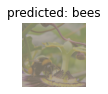

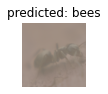

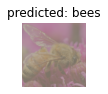

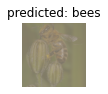

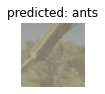

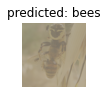

In [76]:
visualize_model(model_ft)

plt.ioff()
plt.show()

###Train Only FC layers

In [77]:
optimizer_conv = optim.Adam(model_conv.fc.parameters(), lr=0.001)

In [78]:
# Learnable Layer 갯수 확인
learnable = 0
for layer in model_conv.parameters():
    if layer.requires_grad:
        learnable += 1
print(learnable)        # weight and bias

2


In [79]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.4305 Acc: 0.8033
val Loss: 0.2250 Acc: 0.9281

Epoch 1/24
----------
train Loss: 0.4132 Acc: 0.8033
val Loss: 0.3195 Acc: 0.8758

Epoch 2/24
----------
train Loss: 0.4091 Acc: 0.8115
val Loss: 0.2103 Acc: 0.9281

Epoch 3/24
----------
train Loss: 0.4633 Acc: 0.7705
val Loss: 0.2079 Acc: 0.9346

Epoch 4/24
----------
train Loss: 0.3621 Acc: 0.8361
val Loss: 0.2045 Acc: 0.9346

Epoch 5/24
----------
train Loss: 0.4180 Acc: 0.8074
val Loss: 0.2177 Acc: 0.9281

Epoch 6/24
----------
train Loss: 0.3335 Acc: 0.8443
val Loss: 0.2089 Acc: 0.9477

Epoch 7/24
----------
train Loss: 0.3138 Acc: 0.8648
val Loss: 0.2197 Acc: 0.9281

Epoch 8/24
----------
train Loss: 0.3966 Acc: 0.7951
val Loss: 0.1981 Acc: 0.9412

Epoch 9/24
----------
train Loss: 0.3998 Acc: 0.8279
val Loss: 0.1961 Acc: 0.9412

Epoch 10/24
----------
train Loss: 0.4138 Acc: 0.8279
val Loss: 0.2056 Acc: 0.9412

Epoch 11/24
----------
train Loss: 0.4181 Acc: 0.7910
val Loss: 0.2057 Acc: 0.9346

Ep

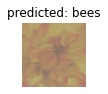

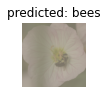

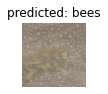

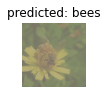

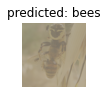

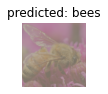

In [80]:
visualize_model(model_conv)

plt.ioff()
plt.show()

##With LR 0.0001

###Train All Layers

In [81]:
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.0001)

In [82]:
#Freeze 된 layer 갯수 확인
Not_learnable = 0
for layer in model_ft.parameters():
    if not layer.requires_grad:
        Not_learnable += 1
print(Not_learnable)

0


In [83]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5423 Acc: 0.7254
val Loss: 0.5269 Acc: 0.7647

Epoch 1/24
----------
train Loss: 0.5391 Acc: 0.7377
val Loss: 0.4130 Acc: 0.8235

Epoch 2/24
----------
train Loss: 0.4767 Acc: 0.7951
val Loss: 0.3941 Acc: 0.8431

Epoch 3/24
----------
train Loss: 0.4722 Acc: 0.7828
val Loss: 0.3748 Acc: 0.8497

Epoch 4/24
----------
train Loss: 0.5009 Acc: 0.7541
val Loss: 0.4930 Acc: 0.8039

Epoch 5/24
----------
train Loss: 0.4276 Acc: 0.8238
val Loss: 0.4338 Acc: 0.8170

Epoch 6/24
----------
train Loss: 0.4738 Acc: 0.7623
val Loss: 0.4632 Acc: 0.7582

Epoch 7/24
----------
train Loss: 0.4886 Acc: 0.7705
val Loss: 0.4424 Acc: 0.8105

Epoch 8/24
----------
train Loss: 0.4390 Acc: 0.7746
val Loss: 0.4940 Acc: 0.8105

Epoch 9/24
----------
train Loss: 0.3758 Acc: 0.8320
val Loss: 0.5158 Acc: 0.7908

Epoch 10/24
----------
train Loss: 0.4075 Acc: 0.8320
val Loss: 0.4936 Acc: 0.8170

Epoch 11/24
----------
train Loss: 0.4618 Acc: 0.7910
val Loss: 0.4330 Acc: 0.8170

Ep

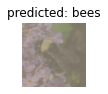

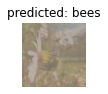

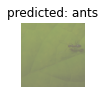

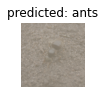

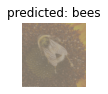

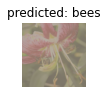

In [84]:
visualize_model(model_ft)

plt.ioff()
plt.show()

###Train Only FC layers

In [85]:
optimizer_conv = optim.Adam(model_conv.fc.parameters(), lr=0.0001)

In [86]:
# Learnable Layer 갯수 확인
learnable = 0
for layer in model_conv.parameters():
    if layer.requires_grad:
        learnable += 1
print(learnable)        # weight and bias

2


In [87]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.4586 Acc: 0.8156
val Loss: 0.2112 Acc: 0.9346

Epoch 1/24
----------
train Loss: 0.3321 Acc: 0.8607
val Loss: 0.2153 Acc: 0.9346

Epoch 2/24
----------
train Loss: 0.3688 Acc: 0.8607
val Loss: 0.2176 Acc: 0.9346

Epoch 3/24
----------
train Loss: 0.3383 Acc: 0.8443
val Loss: 0.2195 Acc: 0.9281

Epoch 4/24
----------
train Loss: 0.3165 Acc: 0.8730
val Loss: 0.2219 Acc: 0.9085

Epoch 5/24
----------
train Loss: 0.3220 Acc: 0.8648
val Loss: 0.1925 Acc: 0.9477

Epoch 6/24
----------
train Loss: 0.4847 Acc: 0.7787
val Loss: 0.2070 Acc: 0.9346

Epoch 7/24
----------
train Loss: 0.3359 Acc: 0.8689
val Loss: 0.2024 Acc: 0.9346

Epoch 8/24
----------
train Loss: 0.3519 Acc: 0.8566
val Loss: 0.1977 Acc: 0.9346

Epoch 9/24
----------
train Loss: 0.4481 Acc: 0.8115
val Loss: 0.2091 Acc: 0.9412

Epoch 10/24
----------
train Loss: 0.3665 Acc: 0.8443
val Loss: 0.2072 Acc: 0.9412

Epoch 11/24
----------
train Loss: 0.4022 Acc: 0.8074
val Loss: 0.2192 Acc: 0.9412

Ep

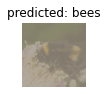

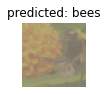

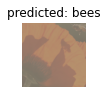

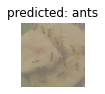

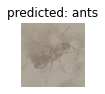

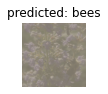

In [88]:
visualize_model(model_conv)

plt.ioff()
plt.show()

#Further Learning

Train 함수를 약간 변형

- BCE Loss를 위해서 labels.float().view(-1,1)

In [89]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)        #pred = 0 or 1
                    loss = criterion(outputs, labels.float().view(-1,1))       #BCEWithLogit

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

1. Resnet의 adaptive average pool 2d를 adaptive max pool 2d로 교체

In [90]:
model = models.resnet18(pretrained=True)

In [91]:
print(model.avgpool)

AdaptiveAvgPool2d(output_size=(1, 1))


In [92]:
model.avgpool = nn.AdaptiveMaxPool2d(output_size=(1,1))

In [93]:
print(model.avgpool)

AdaptiveMaxPool2d(output_size=(1, 1))


2. 마지막 fc layer와 batchnorm의 gamma, beta를 Learnable하게 변경

In [94]:
for param in model.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
# 새로 지정해서 requires_grad = True로 만들어줌
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 1)       #-> BCELoss with Logit을 사용하기 위해 1로 마지막을 만든다

In [95]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [96]:
# BatchNorm이 있는 layer의 param을 learnable하게 만든다

for name, param in model.named_parameters():
    if 'bn' in name:
        param.requires_grad = True
    if 'downsample.1' in name:
        param.requires_grad = True

In [97]:
# 체킹
for param in model.bn1.parameters():
    print(param.requires_grad)

True
True


In [98]:
# 모든 layer의 param 체킹
for name, param in model.named_parameters():
    print(f'name:{name}') 
    print(type(param)) 
    print(f'param.shape:{param.shape}') 
    print(f'param.requries_grad:{param.requires_grad}') 
    print('=====')
    print()

name:conv1.weight
<class 'torch.nn.parameter.Parameter'>
param.shape:torch.Size([64, 3, 7, 7])
param.requries_grad:False
=====

name:bn1.weight
<class 'torch.nn.parameter.Parameter'>
param.shape:torch.Size([64])
param.requries_grad:True
=====

name:bn1.bias
<class 'torch.nn.parameter.Parameter'>
param.shape:torch.Size([64])
param.requries_grad:True
=====

name:layer1.0.conv1.weight
<class 'torch.nn.parameter.Parameter'>
param.shape:torch.Size([64, 64, 3, 3])
param.requries_grad:False
=====

name:layer1.0.bn1.weight
<class 'torch.nn.parameter.Parameter'>
param.shape:torch.Size([64])
param.requries_grad:True
=====

name:layer1.0.bn1.bias
<class 'torch.nn.parameter.Parameter'>
param.shape:torch.Size([64])
param.requries_grad:True
=====

name:layer1.0.conv2.weight
<class 'torch.nn.parameter.Parameter'>
param.shape:torch.Size([64, 64, 3, 3])
param.requries_grad:False
=====

name:layer1.0.bn2.weight
<class 'torch.nn.parameter.Parameter'>
param.shape:torch.Size([64])
param.requries_grad:True


3. 여러 조건들에서 Training

- Optimizer : Adam
- Lr : 0.0001
- Transform : 원본 그대로
- Batch size : 4, 16  
    -> DataLoader에서 바꿔야 함
- Loss function : Binary cross entropy with logit loss

##Batch 4

In [99]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/gdrive/MyDrive/Colab Notebooks/2021W_Postech_Study/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,      # Batch 4
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [100]:
model = model.to(device)

criterion = nn.BCEWithLogitsLoss()      #Loss

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer = optim.Adam(model.fc.parameters(), lr=0.0001)      #Adam, Lr

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

Train and evaluate
^^^^^^^^^^^^^^^^^^

On CPU this will take about half the time compared to previous scenario.
This is expected as gradients don't need to be computed for most of the
network. However, forward does need to be computed.

In [101]:
model = train_model(model, criterion, optimizer,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.9237 Acc: 0.5041
val Loss: 0.9109 Acc: 0.4575

Epoch 1/24
----------
train Loss: 0.8813 Acc: 0.5041
val Loss: 0.8291 Acc: 0.4575

Epoch 2/24
----------
train Loss: 0.7155 Acc: 0.5041
val Loss: 0.8027 Acc: 0.4575

Epoch 3/24
----------
train Loss: 0.7601 Acc: 0.5041
val Loss: 0.7392 Acc: 0.4575

Epoch 4/24
----------
train Loss: 0.6993 Acc: 0.5041
val Loss: 0.6827 Acc: 0.4575

Epoch 5/24
----------
train Loss: 0.7605 Acc: 0.5041
val Loss: 0.6182 Acc: 0.4575

Epoch 6/24
----------
train Loss: 0.6562 Acc: 0.5041
val Loss: 0.5882 Acc: 0.4575

Epoch 7/24
----------
train Loss: 0.6262 Acc: 0.5041
val Loss: 0.5901 Acc: 0.4575

Epoch 8/24
----------
train Loss: 0.6642 Acc: 0.5041
val Loss: 0.5696 Acc: 0.4575

Epoch 9/24
----------
train Loss: 0.6790 Acc: 0.5041
val Loss: 0.5760 Acc: 0.4575

Epoch 10/24
----------
train Loss: 0.6265 Acc: 0.5041
val Loss: 0.5830 Acc: 0.4575

Epoch 11/24
----------
train Loss: 0.5968 Acc: 0.5041
val Loss: 0.6055 Acc: 0.4575

Epoch 12/24
----------
t

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


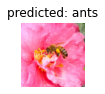

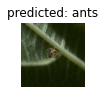

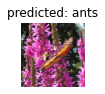

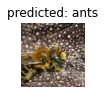

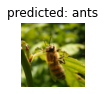

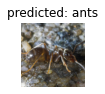

In [102]:
visualize_model(model)

plt.ioff()
plt.show()

##Batch 16

In [103]:
# Batch 16
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/gdrive/MyDrive/Colab Notebooks/2021W_Postech_Study/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16,      #16
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [104]:
model = model.to(device)

criterion = nn.BCEWithLogitsLoss()      #Loss

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer = optim.Adam(model.fc.parameters(), lr=0.0001)      #Adam, Lr

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [105]:
# 모든 layer의 param 체킹

for name, param in model.named_parameters():
    print(f'name:{name}') 
    print(type(param)) 
    print(f'param.shape:{param.shape}') 
    print(f'param.requries_grad:{param.requires_grad}') 
    print('=====')
    print()

name:conv1.weight
<class 'torch.nn.parameter.Parameter'>
param.shape:torch.Size([64, 3, 7, 7])
param.requries_grad:False
=====

name:bn1.weight
<class 'torch.nn.parameter.Parameter'>
param.shape:torch.Size([64])
param.requries_grad:True
=====

name:bn1.bias
<class 'torch.nn.parameter.Parameter'>
param.shape:torch.Size([64])
param.requries_grad:True
=====

name:layer1.0.conv1.weight
<class 'torch.nn.parameter.Parameter'>
param.shape:torch.Size([64, 64, 3, 3])
param.requries_grad:False
=====

name:layer1.0.bn1.weight
<class 'torch.nn.parameter.Parameter'>
param.shape:torch.Size([64])
param.requries_grad:True
=====

name:layer1.0.bn1.bias
<class 'torch.nn.parameter.Parameter'>
param.shape:torch.Size([64])
param.requries_grad:True
=====

name:layer1.0.conv2.weight
<class 'torch.nn.parameter.Parameter'>
param.shape:torch.Size([64, 64, 3, 3])
param.requries_grad:False
=====

name:layer1.0.bn2.weight
<class 'torch.nn.parameter.Parameter'>
param.shape:torch.Size([64])
param.requries_grad:True


In [106]:
model = train_model(model, criterion, optimizer,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.9094 Acc: 0.5041
val Loss: 0.8857 Acc: 0.4575

Epoch 1/24
----------
train Loss: 0.8124 Acc: 0.5041
val Loss: 0.8308 Acc: 0.4575

Epoch 2/24
----------
train Loss: 0.7623 Acc: 0.5041
val Loss: 0.7913 Acc: 0.4575

Epoch 3/24
----------
train Loss: 0.7397 Acc: 0.5041
val Loss: 0.7255 Acc: 0.4575

Epoch 4/24
----------
train Loss: 0.7554 Acc: 0.5041
val Loss: 0.6825 Acc: 0.4575

Epoch 5/24
----------
train Loss: 0.6992 Acc: 0.5041
val Loss: 0.6576 Acc: 0.4575

Epoch 6/24
----------
train Loss: 0.6652 Acc: 0.5041
val Loss: 0.6441 Acc: 0.4575

Epoch 7/24
----------
train Loss: 0.6414 Acc: 0.5041
val Loss: 0.6434 Acc: 0.4575

Epoch 8/24
----------
train Loss: 0.6208 Acc: 0.5041
val Loss: 0.6565 Acc: 0.4575

Epoch 9/24
----------
train Loss: 0.6359 Acc: 0.5041
val Loss: 0.6510 Acc: 0.4575

Epoch 10/24
----------
train Loss: 0.6749 Acc: 0.5041
val Loss: 0.6152 Acc: 0.4575

Epoch 11/24
----------
train Loss: 0.6824 Acc: 0.5041
val Loss: 0.6370 Acc: 0.4575

Epoch 12/24
----------
t

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


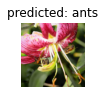

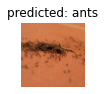

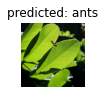

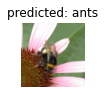

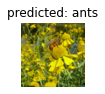

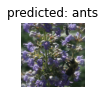

In [107]:
visualize_model(model)

plt.ioff()
plt.show()